In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel
from transformers import AutoModelForImageClassification, AutoImageProcessor
from datasets import load_dataset
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
import pickle
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Shankar\.conda\envs\DL-1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model Names
MODEL_NAMES = {
    "dino_v2": "facebook/dinov2-large",
    "swin": "microsoft/swin-tiny-patch4-window7-224",
    "vit": "google/vit-base-patch16-224"
}

In [61]:
dataset = load_dataset("imagefolder", data_dir="./data/training_data")

def transform_ds(image_processor):
    test_ds = dataset["test"]
    normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    
    if "height" in image_processor.size:
        size = (image_processor.size["height"], image_processor.size["width"])
        crop_size = size
        max_size = None
    elif "shortest_edge" in image_processor.size:
        size = image_processor.size["shortest_edge"]
        crop_size = (size, size)
        max_size = image_processor.size.get("longest_edge")
    
    val_transforms = Compose(
            [
                Resize(size),
                CenterCrop(crop_size),
                ToTensor(),
                normalize,
            ]
        )
    
    def preprocess_val(example_batch):
        """Apply val_transforms across a batch."""
        example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
        return example_batch

    test_ds.set_transform(preprocess_val)
    return test_ds

In [59]:
fpth = r'C:/Users/Shankar/Desktop/goat-ipython/goat-vault/goat-vault/01 - Notes/03 - Resources/Codes/CMI/AML/Project/Training/';
for model_type in MODEL_NAMES:
        print(f"Starting evaluation for {model_type}...")
        # Initialize lists to store predicted and actual labels
        predicted_labels = []
        actual_labels = []
        all_top5_probs = []
        all_top5 = []
        
        model_name = MODEL_NAMES[model_type]
        image_processor  = AutoImageProcessor.from_pretrained(model_name)
        # Load the model from SafeTensors format
    
        model = AutoModelForImageClassification.from_pretrained(fpth  + model_type + "-finetuned-dermnet", device_map="auto").to(device)
        
        model.eval()
        test_ds = transform_ds(image_processor)
        
        for example in test_ds:
            image = example["image"]
            encoding = image_processor(image.convert("RGB"), return_tensors="pt").to(device)
    
            with torch.no_grad():
                outputs = model(**encoding)
                logits = outputs.logits
            

            predicted_class_idx = logits.argmax(-1).item()

            probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
            # Get top 5 predictions
            top5_probs, top5_indices = torch.topk(probabilities, 5)
        
            # Convert to list format
            top5_probs = top5_probs.squeeze().tolist()
            top5_indices = top5_indices.squeeze().tolist()

            all_top5_probs.append(top5_probs)
            all_top5.append(top5_indices)
            
            predicted_labels.append(predicted_class_idx)
            actual_labels.append(example["label"])

        with open(model_type+ '_predictions.pkl', 'wb') as f: 
            pickle.dump([predicted_labels, actual_labels, all_top5, all_top5_probs], f)
        # Calculate accuracy
        accuracy = accuracy_score(actual_labels, predicted_labels)
        
        print(f"Test Accuracy for {model_type}: {accuracy:.4f}")

Starting evaluation for dino_v2...
Test Accuracy for dino_v2: 0.7850
Starting evaluation for swin...
Test Accuracy for swin: 0.6953
Starting evaluation for vit...


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Test Accuracy for vit: 0.7324


In [4]:
# Getting back the objects:
with open('dino_v2_predictions.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    predicted_labels, actual_labels, all_top5, all_top5_probs  = pickle.load(f)

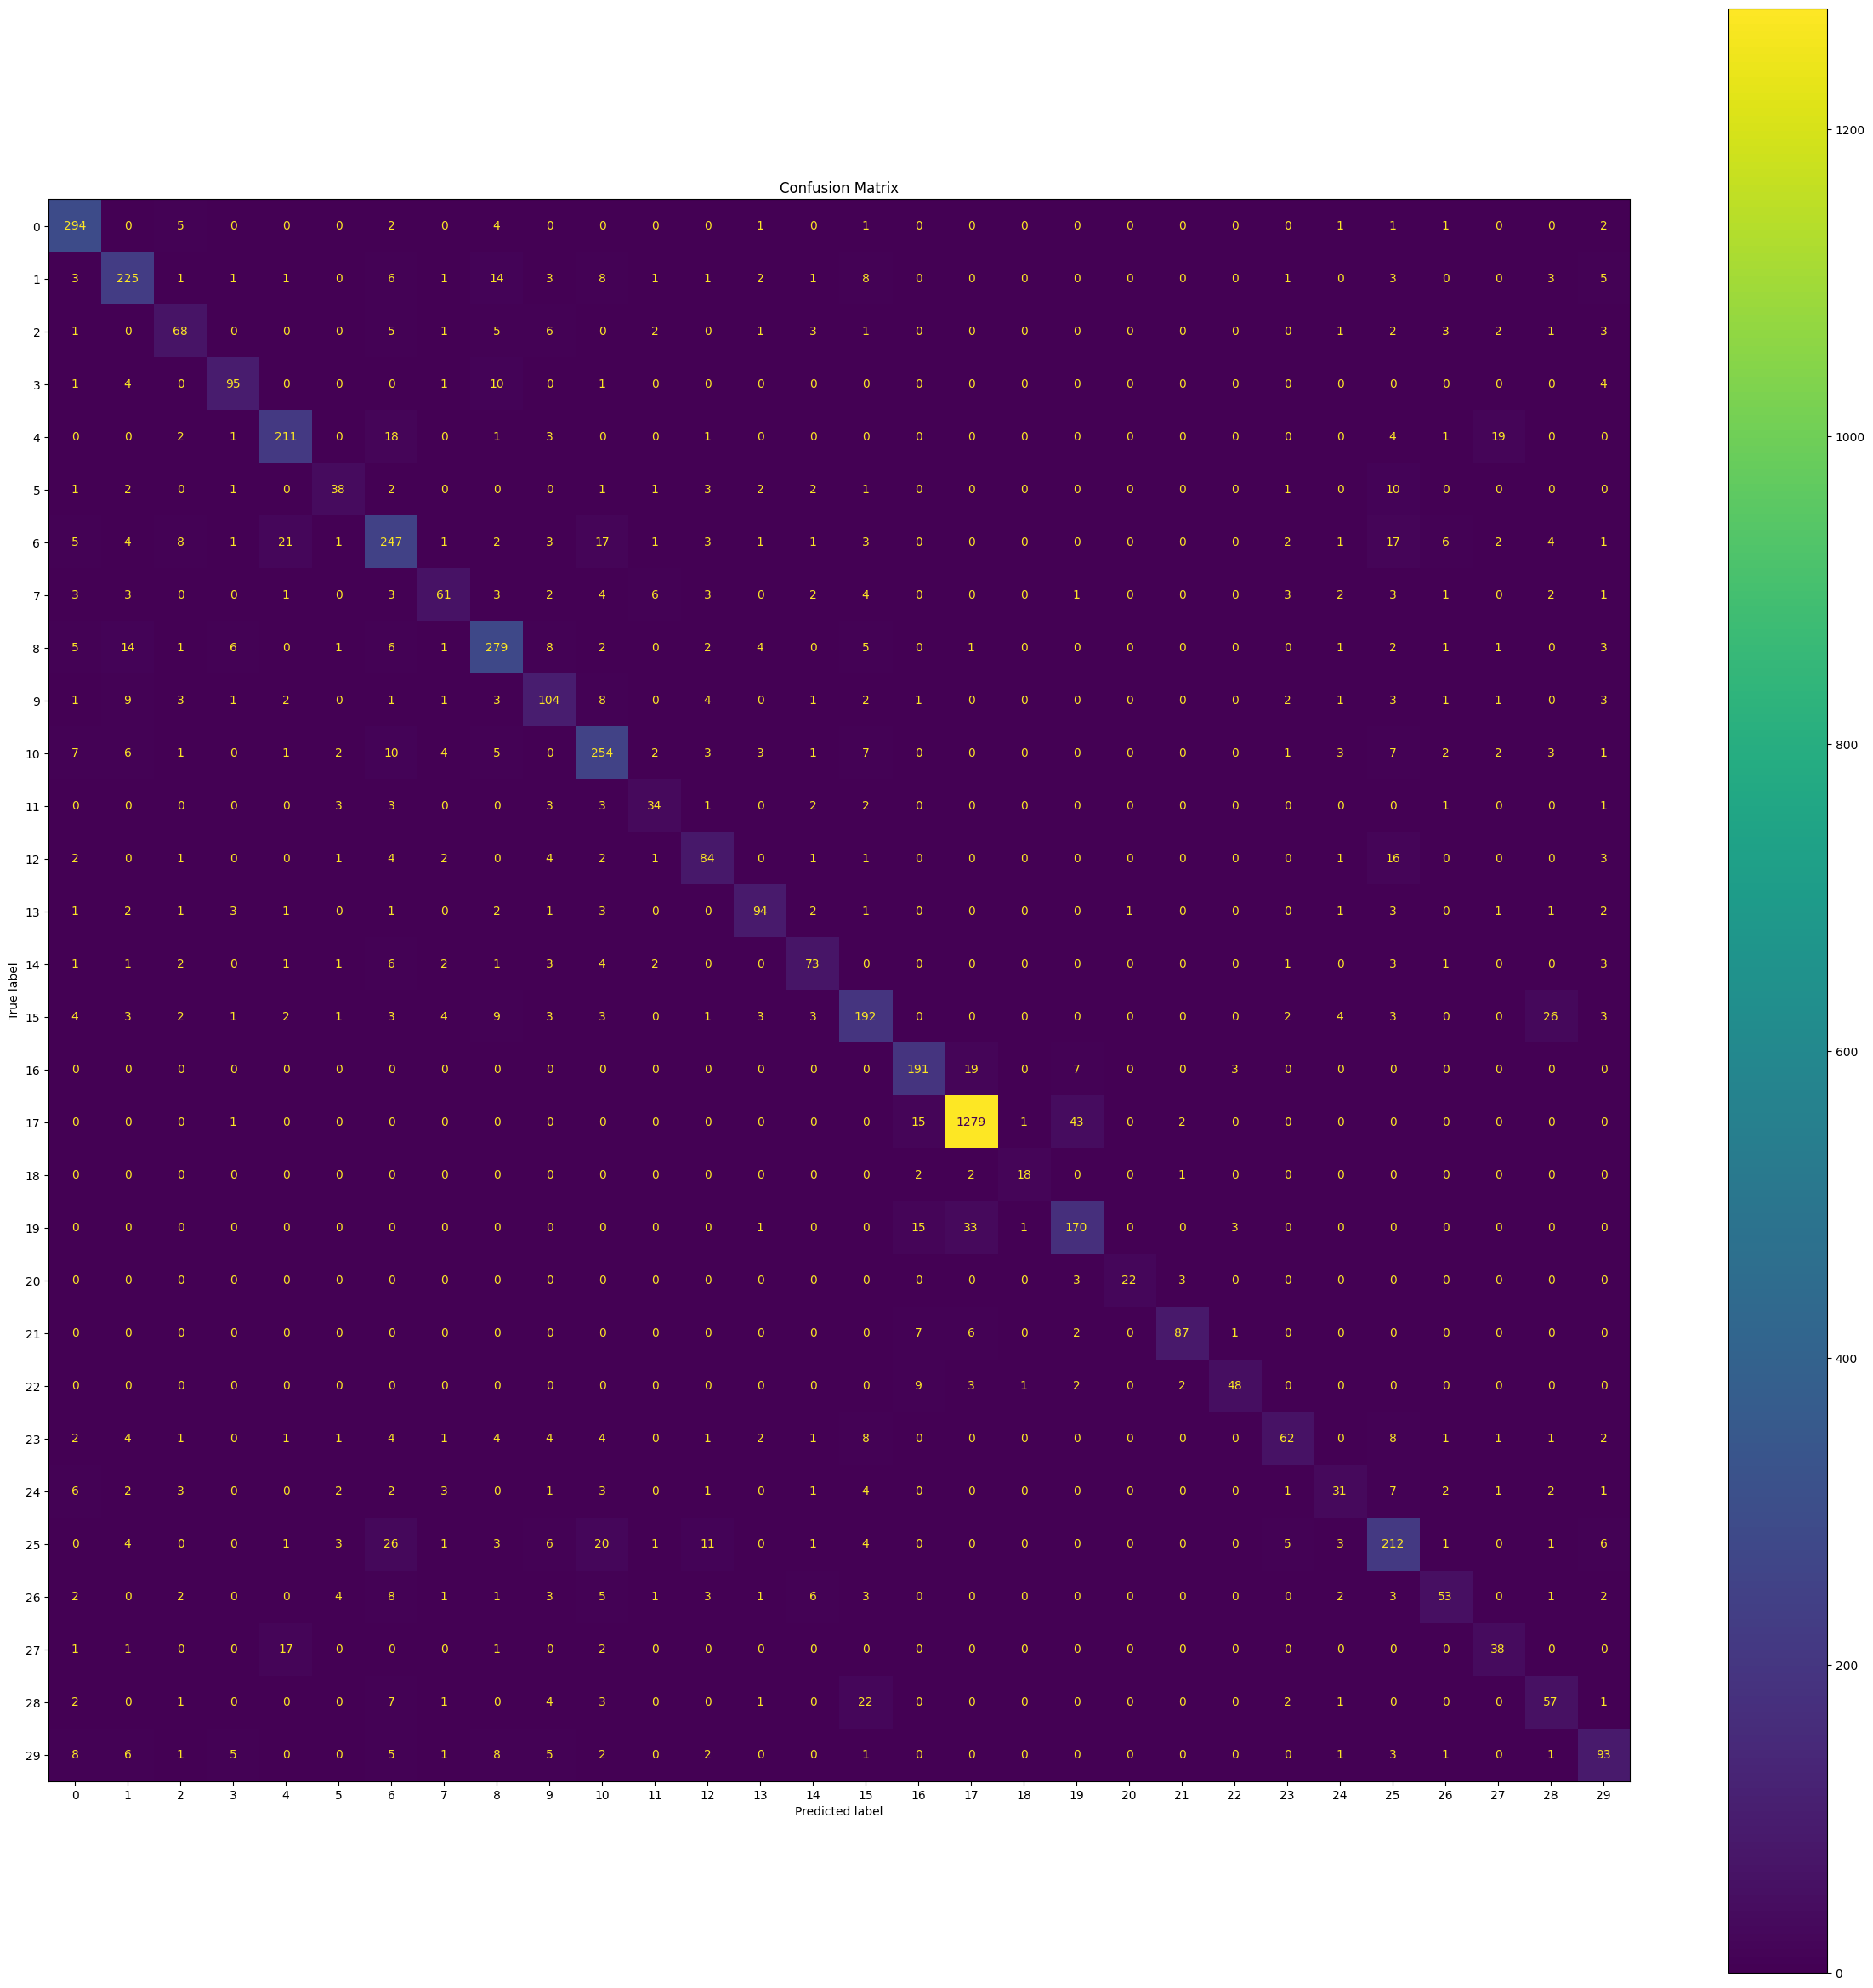

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,1,figsize=(30,30))
ConfusionMatrixDisplay.from_predictions(actual_labels, predicted_labels, ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [57]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       312
           1       0.78      0.78      0.78       288
           2       0.66      0.65      0.65       105
           3       0.82      0.82      0.82       116
           4       0.81      0.81      0.81       261
           5       0.66      0.58      0.62        65
           6       0.67      0.70      0.69       352
           7       0.70      0.56      0.63       108
           8       0.79      0.81      0.80       343
           9       0.63      0.68      0.65       152
          10       0.73      0.78      0.75       325
          11       0.65      0.64      0.65        53
          12       0.68      0.68      0.68       123
          13       0.81      0.78      0.79       121
          14       0.72      0.70      0.71       105
          15       0.71      0.71      0.71       272
          16       0.80      0.87      0.83       220
          17       0.95    

In [21]:
dataset = load_dataset("imagefolder", data_dir="./data/training_data")

In [22]:
labels = dataset["train"].features["label"].names

In [30]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label[2])

10


In [31]:
label2id

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '4': 24,
 '5': 25,
 '6': 26,
 '7': 27,
 '8': 28,
 '9': 29}

In [45]:
id2label = {}
for key in label2id:
    id2label[str(label2id[key])] = key

In [46]:
with open('id2label.pkl', 'wb') as f: 
    pickle.dump(id2label, f)

In [51]:
with open('id2label.pkl', 'rb') as f:
    id2label  = pickle.load(f)
    
top_indices = [2,5,6,9, 15]
top_indices = [int(id2label[str(ind)]) for ind in top_indices]

In [55]:
id2label

{'0': '0',
 '1': '1',
 '2': '10',
 '3': '11',
 '4': '12',
 '5': '13',
 '6': '14',
 '7': '15',
 '8': '16',
 '9': '17',
 '10': '18',
 '11': '19',
 '12': '2',
 '13': '20',
 '14': '21',
 '15': '22',
 '16': '23',
 '17': '24',
 '18': '25',
 '19': '26',
 '20': '27',
 '21': '28',
 '22': '29',
 '23': '3',
 '24': '4',
 '25': '5',
 '26': '6',
 '27': '7',
 '28': '8',
 '29': '9'}

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from tabulate import tabulate
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# Color Theme for Confusion Matrix
blue_white_cmap = sns.light_palette("blue", as_cmap=True)

# Figure size settings
image_size = 500
spacing = 50

for idx in MODEL_NAMES:
    with open(idx + '_predictions.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
        predicted_labels, actual_labels, all_top5, all_top5_probs  = pickle.load(f)

    actual_labels = np.array(actual_labels)
    predicted_labels = np.array(predicted_labels)
    all_top5 = np.array(all_top5)
    all_top5_probs = np.array(all_top5_probs)
    
    top1_acc = sum(actual_labels == predicted_labels)/len(actual_labels)
    top1_acc *= 100

    num = 0
    den = 0
    for row in range(len(actual_labels)):
        if actual_labels[row] in all_top5[row][0:3]:
            num = num + 1
        den = den + 1

    top3_acc = num/den
    top3_acc *= 100

    cols = 2
    rows = 2
    collage_width = cols * image_size + (cols - 1) * spacing
    collage_height = rows * image_size + (rows - 1) * spacing
    collage = np.ones((collage_height, collage_width, 3), dtype=np.uint8) * 255  # White background

    report = classification_report(actual_labels, predicted_labels,output_dict=True)
    cm = confusion_matrix(actual_labels, predicted_labels)
    
    plt.figure(figsize=(8, 8))  # Bigger size for clarity
    sns.heatmap(cm, annot=True, fmt="d", cmap=blue_white_cmap, cbar=False, square=True)
    plt.title(f"{idx} Confusion Matrix", fontweight="bold", fontsize=14)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout(pad=2)  # Extra padding
    plt.savefig(f"conf_matrix_{idx}.png", dpi=300)
    plt.close()

    plt.figure(figsize=(6, 6))
    plt.title(f"{idx} Classification Report", fontweight="bold", fontsize=14)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
    plt.tight_layout(pad=2)  # Extra padding
    plt.savefig(f"class_report_{idx}.png", dpi=300)
    plt.close()


    # Load images
    conf_img = cv2.imread(f"conf_matrix_{idx}.png")
    conf_img = cv2.resize(conf_img, (500, 500)) 
    report_img = cv2.imread(f"class_report_{idx}.png")
    report_img = cv2.resize(report_img, (500, 500))

    collage[0:image_size, 0:image_size, :] = conf_img
    collage[0:image_size, 550:550+image_size, :] = report_img


    # Add Text for Accuracy
    plt.figure(figsize=(3, 3))
    plt.text(0.1, 0.7, f"Top-1 Accuracy: {top1_acc:.2f}%", fontsize=12, fontweight="bold", color="blue")
    plt.text(0.1, 0.5, f"Top-3 Accuracy: {top3_acc:.2f}%", fontsize=12, fontweight="bold", color="blue")
    plt.axis("off")
    plt.savefig(f"accuracy_{idx}.png", dpi=300)
    plt.close()

    
    acc_img = cv2.imread(f"accuracy_{idx}.png")
    acc_img = cv2.resize(acc_img, (200, 200))
    
    collage[500:700, 200:400, :] = acc_img

    cv2.imwrite(f'collage_{idx}.png', collage)

# Save Final Collage
print("Final collage saved")

Final collage saved


In [ ]:
23,24,25,26,27,28,0,12,16

In [ ]:
Acne and Rosacea Photos

In [ ]:
Seborrheic Keratoses and other Benign Tumors

In [ ]:
Melanocytic nevi

In [ ]:
Dermatofibroma

In [ ]:
Nail Fungus and other Nail Disease